In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

In [2]:
# Previous lines are to test the Word2Vec model
# Code starts here
# Reading Hansen and SMILES data from gpHSP
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')

mol_smiles = gpHSP_data['SMILES']
hansen_d = gpHSP_data['hansen_d']
hansen_p = gpHSP_data['hansen_p']
hansen_h = gpHSP_data['hansen_h']
mol_number = gpHSP_data['number']
mol_name = gpHSP_data['Molecule']

# hansen_total = np.sqrt((hansen_d*hansen_d + hansen_p*hansen_p + hansen_h*hansen_h))

In [3]:
from gensim.models import word2vec

In [4]:
model = word2vec.Word2Vec.load('mol2vec/examples/models/model_300dim.pkl')

In [5]:
# Extraction of identifiers from molecules
mmm = [Chem.MolFromSmiles(x) for x in mol_smiles]
aa_sentences = [mol2alt_sentence(x, 1) for x in mmm]

In [6]:
#Generate "molecular sentences" that are then used to featurize the molecules 
#(i.e. vectors of identifiers are extracted from Mol2vec model and summed up)
 
aa_mol2vec = [DfVec(x) for x in sentences2vec(aa_sentences, model, unseen='UNK')]

In [7]:
np_aa_mol2vec = np.array([x.vec for x in aa_mol2vec])

In [8]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import TensorDataset, DataLoader

In [9]:
#convert data to tensor
mol2vec_tensors = torch.from_numpy(np_aa_mol2vec)

# convert hansen_p to tensor
np_hansen_p = np.asarray(hansen_p)
tensor_p = torch.from_numpy(np_hansen_p)

# convert mol_name to tensor
np_mol_number = np.asarray(mol_number)
tensor_mol_number = torch.from_numpy(np_mol_number)

In [10]:
# standalise mol2vec tensor data
means = mol2vec_tensors.mean(dim=1, keepdim=True)
stds = mol2vec_tensors.std(dim=1, keepdim=True)
mol2vec_tensors_normalized = (mol2vec_tensors - means) / stds

In [11]:
#print(tensor_d.shape)
new_shape=(len(tensor_p),1)
tensor_p = tensor_p.view(new_shape)

# Define dataset
hansen_p_dataset = TensorDataset(mol2vec_tensors_normalized,tensor_p, tensor_mol_number) 

In [12]:
# create random split of data for traning and validation
from torch.utils.data import random_split, ConcatDataset


ds1, ds2, ds3, ds4, ds5, ds6 = random_split(hansen_p_dataset, [183, 200, 200, 200, 200, 200])

# save dataset
torch.save(ds1, 'hansen_p_ds1.pt')
torch.save(ds2, 'hansen_p_ds2.pt')
torch.save(ds3, 'hansen_p_ds3.pt')
torch.save(ds4, 'hansen_p_ds4.pt')
torch.save(ds5, 'hansen_p_ds5.pt')
torch.save(ds6, 'hansen_p_ds6.pt')

In [13]:
batch_size = 64
num_epochs = 100
learning_rate = 1e-4

In [14]:
# Define data loader

train_ds = ConcatDataset ([ds1, ds2, ds3, ds4])

train_dl = DataLoader(train_ds, batch_size, shuffle=False, num_workers=1)
val_dl = DataLoader(ds5, batch_size, shuffle=False, num_workers=1)
test_dl = DataLoader(ds6, batch_size, shuffle=False, num_workers=1)

In [15]:
# define FFNN

class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.layers = nn.Sequential(
             nn.Linear(300,200),
             nn.ReLU(),
             nn.Dropout(p=0.25),
             nn.Linear(200,100),
             nn.ReLU(),
             nn.Dropout(p=0.1),
             nn.Linear(100,10),
             nn.ReLU(),
             nn.Dropout(p=0.05),
             nn.Linear(10,1)
         )
    def forward(self, x):
            output = self.layers(x)
            return output

In [16]:
# Initialte model
ffnn_model = FFNN()

# Define cpu/gpu 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 

# Convert model parameters and buffers to CPU or Cuda 
ffnn_model.to(device)    

The model will be running on cpu device



FFNN(
  (layers): Sequential(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.05, inplace=False)
    (9): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn_model.parameters(), lr= learning_rate)

In [18]:
# Utility function to train the model
train_losses=[]

def ffnn_train(num_epochs):
    print ('\nEpoch : %d'%epoch)
    ffnn_model.train()

    running_loss=0
    
    # Train with batches of data
    for xb,yb,zb in train_dl:
        
        # Forward pass
        preds = ffnn_model(xb).double()
        # Compute Loss
        loss = criterion(preds, yb)       
        # clear gradients
        optimizer.zero_grad()  
        # Backward pass to get gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss_per_epoch = running_loss/len(train_dl)
    train_losses.append(train_loss_per_epoch)
    print ('Train Loss: %.3f'%(train_loss_per_epoch))  

In [19]:
# evaluate the model on the test set  
eval_losses=[]

predictions = []
actuals = []
r2_all = []
np_predictions_all = []
np_actuals_all = []

def ffnn_evaluate(num_epochs):
    ffnn_model.eval()
    
    running_loss_eval=0
    predictions = []
    actuals =[]

    with torch.no_grad():       
        # iterate. through validating dateset
        for xb,yb,zb in val_dl:   
            preds_eval = ffnn_model(xb).double()
            # compute loss
            loss_eval = criterion(preds_eval, yb)
            #loss list
            running_loss_eval += loss_eval.item()
            
            # retrieve numpy array and save predicted values
            preds_mod = preds_eval.detach().numpy()
            actual = yb.detach().numpy()
            predictions.append(preds_mod)
            actuals.append(actual)

    np_predictions = np.concatenate(predictions, axis=0)
    np_actuals = np.concatenate(actuals, axis=0)
    r2_per_epoch = r2_score(np_actuals, np_predictions)
    
    np_predictions_all.append(np_predictions)
    np_actuals_all.append(np_actuals)
    r2_all.append(r2_per_epoch)
    
    eval_loss_per_epoch = running_loss_eval/len(val_dl)
    eval_losses.append(eval_loss_per_epoch)        
    print('Validate Loss: %.3f'%(eval_loss_per_epoch))   
    print('Validate R2: %.3f'%(r2_per_epoch))

In [20]:
for epoch in range(1, num_epochs+1):
    ffnn_train(epoch)
    ffnn_evaluate(epoch)


Epoch : 1
Train Loss: 69.293
Validate Loss: 80.028
Validate R2: -2.993

Epoch : 2
Train Loss: 66.388
Validate Loss: 76.373
Validate R2: -2.812

Epoch : 3
Train Loss: 62.533
Validate Loss: 71.044
Validate R2: -2.548

Epoch : 4
Train Loss: 56.766
Validate Loss: 63.076
Validate R2: -2.156

Epoch : 5
Train Loss: 48.761
Validate Loss: 52.565
Validate R2: -1.639

Epoch : 6
Train Loss: 39.176
Validate Loss: 40.484
Validate R2: -1.047

Epoch : 7
Train Loss: 29.533
Validate Loss: 29.376
Validate R2: -0.507

Epoch : 8
Train Loss: 22.633
Validate Loss: 22.243
Validate R2: -0.169

Epoch : 9
Train Loss: 20.015
Validate Loss: 19.562
Validate R2: -0.047

Epoch : 10
Train Loss: 20.243
Validate Loss: 18.854
Validate R2: -0.013

Epoch : 11
Train Loss: 19.329
Validate Loss: 18.623
Validate R2: 0.002

Epoch : 12
Train Loss: 18.677
Validate Loss: 18.405
Validate R2: 0.016

Epoch : 13
Train Loss: 17.736
Validate Loss: 17.845
Validate R2: 0.044

Epoch : 14
Train Loss: 17.159
Validate Loss: 17.358
Validate R

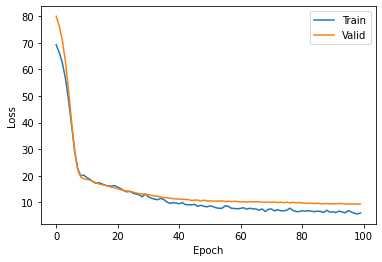

In [21]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train', 'Valid'])
plt.show()

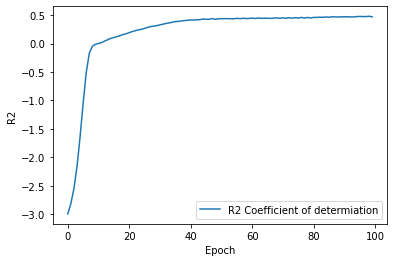

In [22]:
plt.plot(r2_all)
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.legend(['R2 Coefficient of determiation'])
plt.show()

In [23]:
# save the model 
torch.save(ffnn_model.state_dict(), '/Users/jiayun/Documents/work/mol2vec/ffnn_hansen_p_fold1')

# load the model 
# ffnn_model = torch.load('/Users/jiayun/Documents/work/mol2vec/ffnn_hansen_p_fold1')
# load testing data
# test_dl = DataLoader(ds6, batch_size, shuffle=True, num_workers=1)

In [24]:
#use the model on test data
def test_model(test_dl, ffnn_model):
    predictions_test = []
    actuals_test = []
    molecule_number_test = []
    for xb,yb,zb in test_dl:
        # evaluate the model on the test set  
        preds = ffnn_model(xb).double()
        # retrieve numpy array
        preds = preds.detach().numpy()
        actual = yb.detach().numpy()
        molecule_number = zb.detach().numpy()
        # save data
        predictions_test.append(preds)
        actuals_test.append(actual)
        molecule_number_test.append(molecule_number)
    return predictions_test, actuals_test, molecule_number_test     

In [25]:
predictions_test, actuals_test, molecule_number_test = test_model(test_dl, ffnn_model)

In [26]:
np_predictions_test = np.concatenate(predictions_test, axis=0)
np_actuals_test = np.concatenate(actuals_test, axis=0)
np_molecule_number_test = np.concatenate(molecule_number_test, axis=0)

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(np_actuals_test, np_predictions_test))

#RMSEs
print(math.sqrt(mean_squared_error(np_actuals_test, np_predictions_test)))

# R^2 Coefficient of Determination
print(r2_score(np_actuals_test, np_predictions_test))

2.3450050719380378
3.2121980519204483
0.5694867409552169


Text(0, 0.5, 'pred. TSPs')

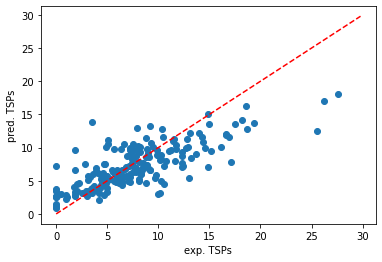

In [30]:
plt.figure(1)

ln = np.arange(0, 30, 0.2)
plt.plot(ln, ln,'r--')
plt.scatter(np_actuals_test, np_predictions_test)
plt.xlabel('exp. TSPs')
plt.ylabel('pred. TSPs')

In [31]:
np_molecule_number_test2 = np_molecule_number_test.reshape(200,1)
pd_mol_number = pd.DataFrame(np_molecule_number_test2, columns = ["number"])
pd_acturals_test = pd.DataFrame(np_actuals_test, columns = ["actual"])
pd_predictions_test = pd.DataFrame(np_predictions_test, columns = ["predict"])
pd_test = pd.concat((pd_mol_number,pd_acturals_test,pd_predictions_test),axis=1)



In [32]:
def mapping(number):
#     print(row['number'])
    return gpHSP_data.loc[gpHSP_data['number'] == number]['SMILES'].iloc[0]

pd_test['SMILES'] = pd_test.apply(lambda row: mapping(row['number']), axis=1)

In [48]:
# save prediction to csv
pd_test.to_csv('hansen_p_word2vec_ffnn_ds6_fold1_results.csv')

In [34]:
pd_test_non_zero = pd_test.loc[pd_test['actual']!=0]

In [35]:
pd_test_non_zero['%_error'] = pd_test_non_zero.apply(lambda x: abs(x['predict']-x['actual'])/x['actual'], axis=1)


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [45]:
pd_test_outliners = pd_test_non_zero.loc[pd_test_non_zero['%_error'] > 0.6]

In [46]:
pd_test_outliners

,number,actual,predict,SMILES,%_error
14,770,3.6,5.964218,IC(I)I,0.656727
20,538,2.2,4.619782,O=C(CCCCCCCCC(=O)OCc1ccccc1)OCc2ccccc2,1.099901
29,630,5.1,10.547369,CNC(C)Cc1ccc2OCOc2c1,1.068112
41,1119,2.0,4.528447,FC(Cl)(Cl)Cl,1.264223
44,952,0.1,2.752639,CCCCc1ccccc1C,26.526391
45,225,2.8,7.567343,Cc1occc1,1.702623
46,585,1.7,4.057827,CC(C)NC(C)C,1.386957
68,73,1.8,9.646358,C1COCCO1,4.359088
70,551,3.1,5.710362,FC(Cl)Cl,0.842052
76,465,3.9,6.492218,OC(=O)\C=C/c1ccccc1,0.664671


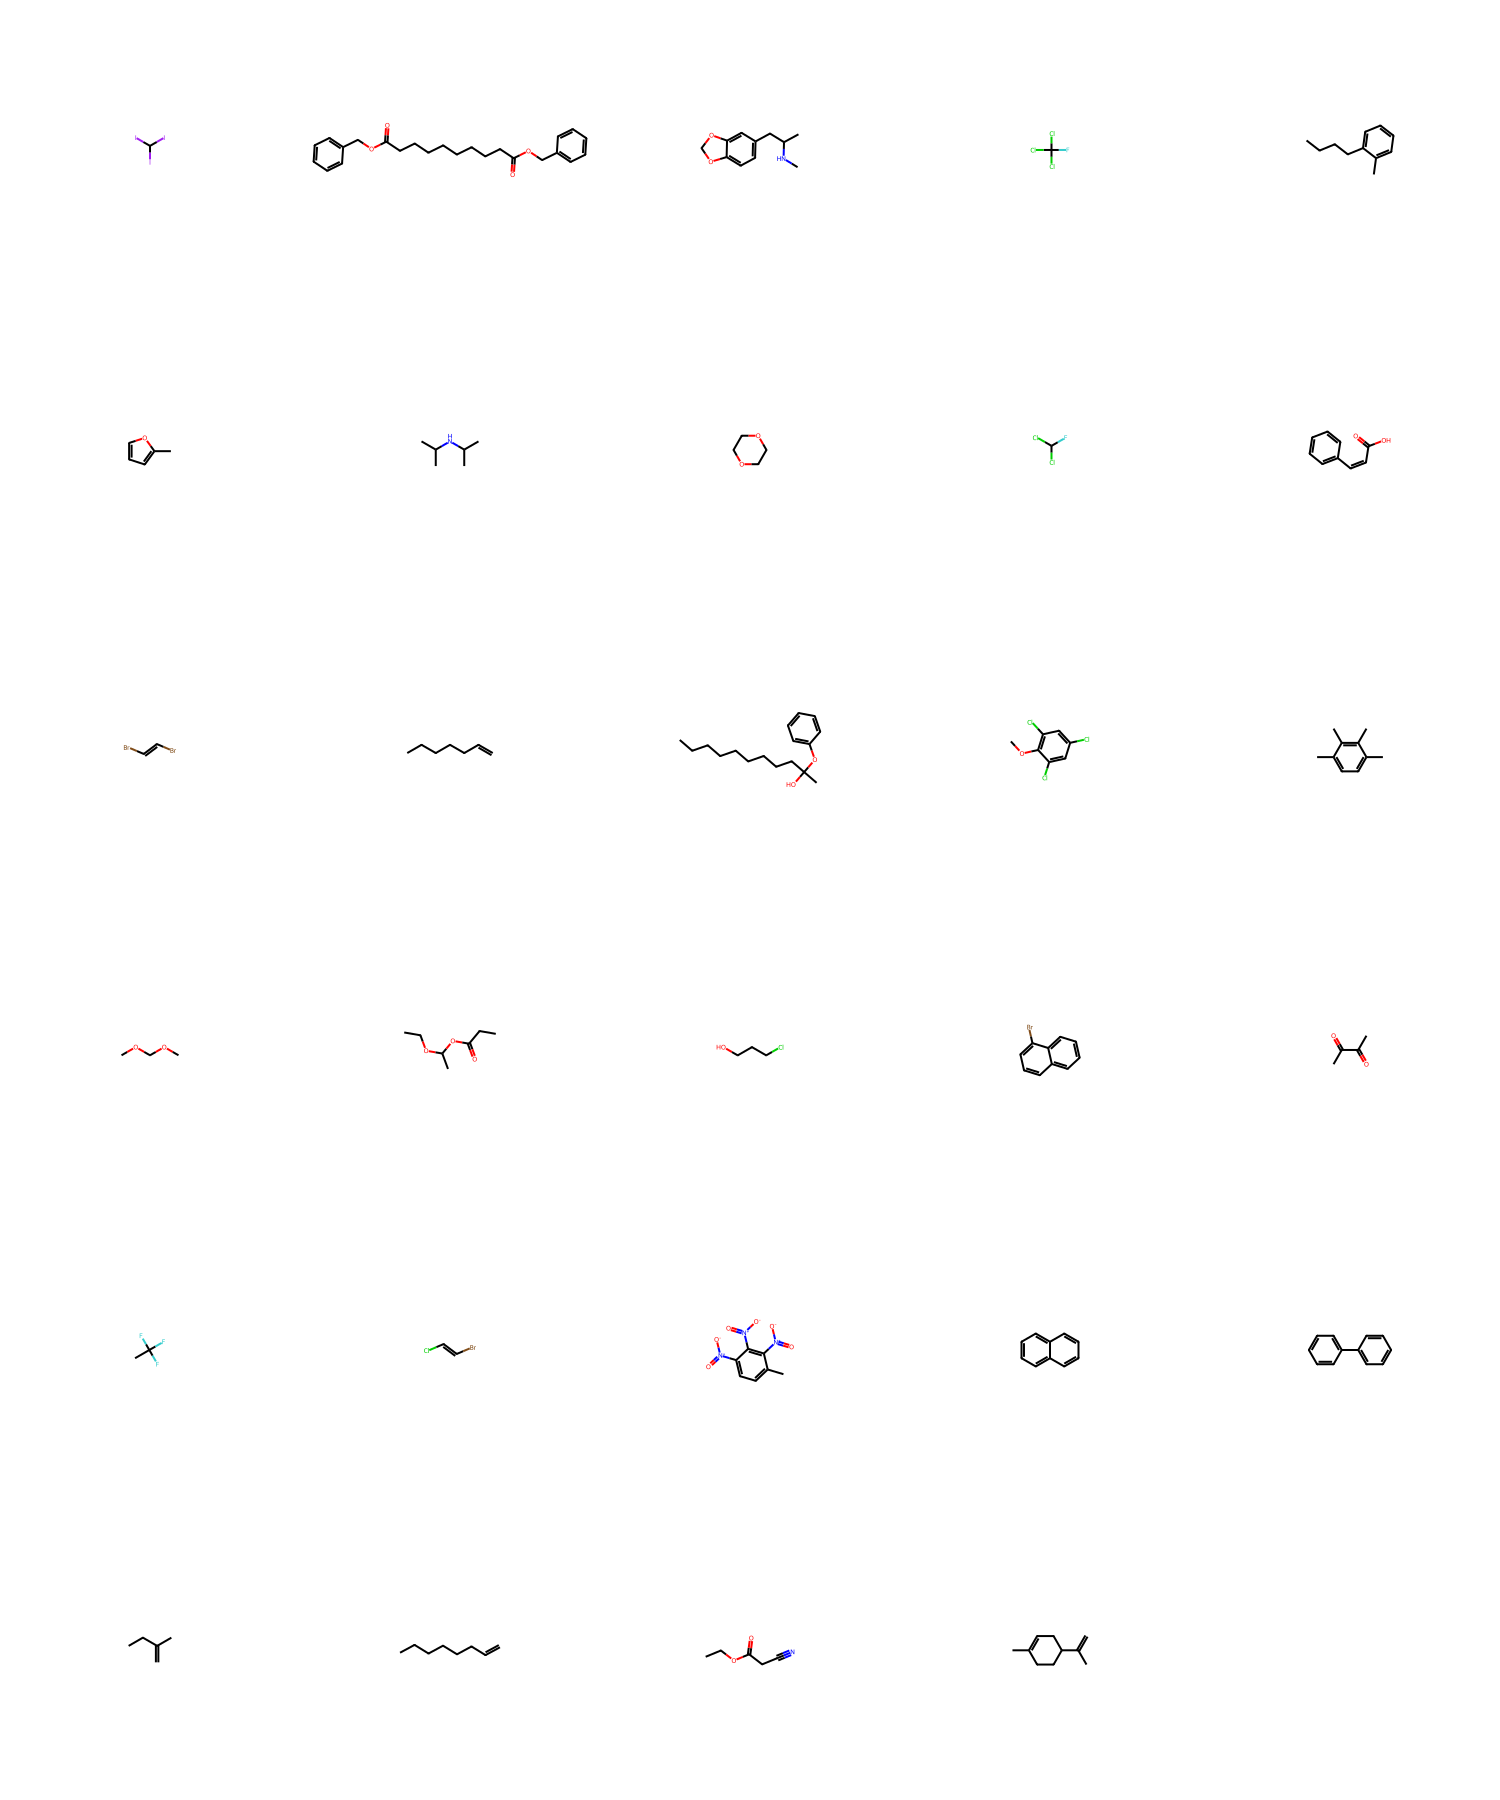

In [47]:
from rdkit.Chem import Draw
outliners = [Chem.MolFromSmiles(x) for x in pd_test_outliners['SMILES']]
Draw.MolsToGridImage(outliners, subImgSize=(300,300), molsPerRow=5, maxMols=50)

In [39]:
pd_test_best = pd_test_non_zero.loc[pd_test_non_zero['%_error'] < 0.05]

In [40]:
pd_test_best

,number,actual,predict,SMILES,%_error
22,676,6.4,6.546664,CCOC#CC,0.022916
28,285,6.0,5.837998,BrCCC=C,0.027000
56,887,11.4,11.007713,CCN(CC)C=O,0.034411
62,296,5.2,5.327736,CCc1ccc(O)cc1,0.024565
86,582,6.3,6.289862,SS,0.001609
97,4,5.1,5.042183,ClC(Cl)C(Cl)Cl,0.011337
106,852,11.5,11.362199,CN=C=O,0.011983
112,594,6.0,5.701684,COCCOC,0.049719
116,378,7.4,7.601159,O=Cc1ccccc1,0.027184
127,396,3.8,3.680417,CCOCc1ccccc1,0.031469


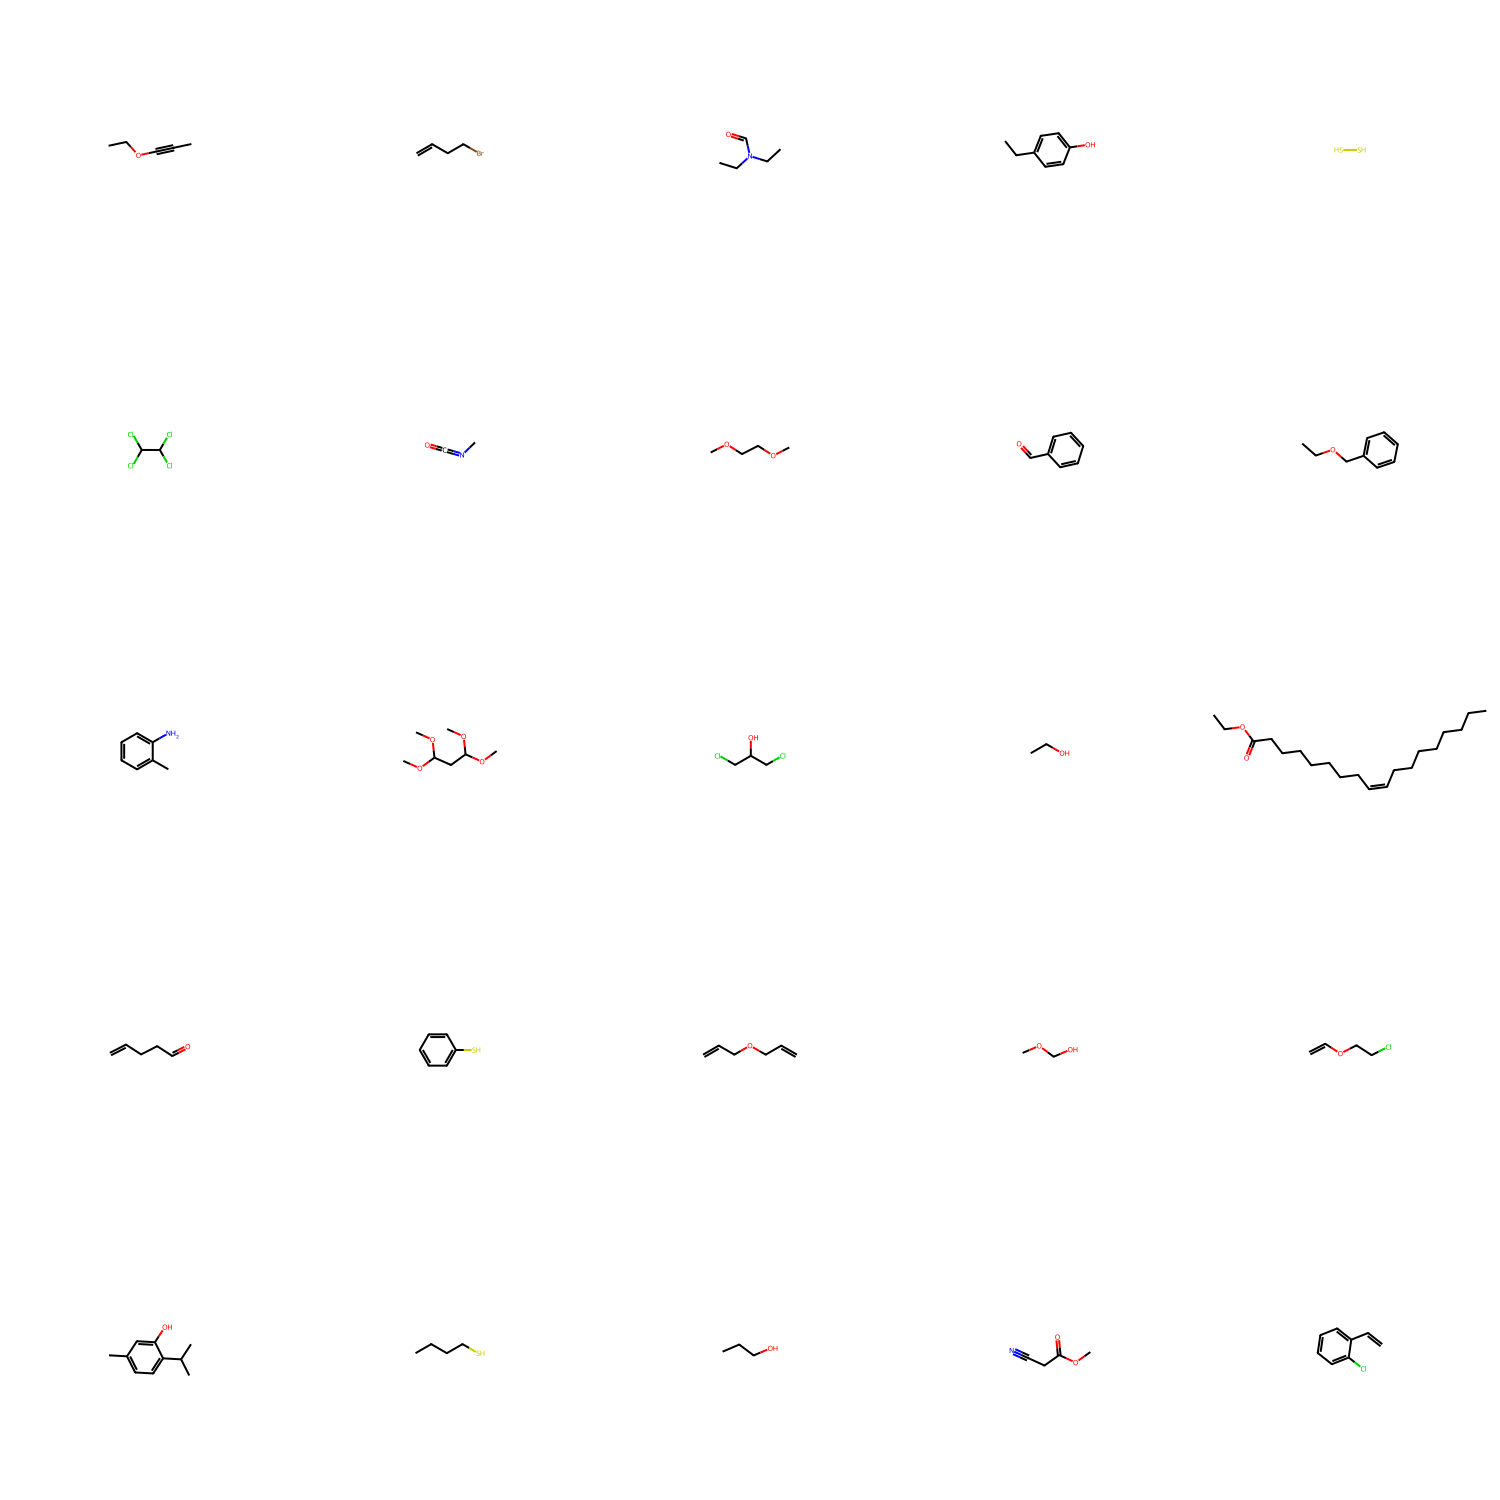

In [41]:
from rdkit.Chem import Draw
best = [Chem.MolFromSmiles(x) for x in pd_test_best['SMILES']]
Draw.MolsToGridImage(best, subImgSize=(300,300), molsPerRow=5, maxMols=150)